# Regresion Logística


**Regresión logística** es una variación que se usa para clasificación binaria (entre 0 y 1).

No es práctico usar una línea recta para estimar probabilidades (que varían entre 0 y 1)

Establece la probabilidad de que la instancia pertenezca a la clase objetivo*

*NO indica que este sea el valor de la variable de respuesta, tal y como es el caso de la regresión lineal



## 1. Librerias y configuraciones previas


In [25]:
# Tratamiento de datos
# ==============================================================================
import pandas as pd
import numpy as np


# Almacenar en caché los resultados de funciones en el disco
# ==============================================================================
import joblib


# Gestion de librerias
# ==============================================================================
from importlib import reload


# Matemáticas y estadísticas
# ==============================================================================
import math


# Preprocesado y modelado
# ==============================================================================


#Separar los datos entrenamiento y prueba
from sklearn.model_selection import train_test_split


#Escalar Variables
from sklearn.preprocessing import MinMaxScaler


#Evaluación del modelo
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve



#Creación de modelo
from sklearn.linear_model import LogisticRegression


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## 2. Funciones

In [26]:
#reload(utils.funciones)

# Funciones externas
# ==============================================================================
from utils.funciones import multiple_plot, plot_roc_curve

## 3. Carga del dataset

In [27]:
#Se crea un dataframe d con los datos obtenidos de archivo de entrada
d=pd.read_csv('./datasets/02_GermanCredit_Prep.csv')

In [28]:
## Cargar datos con colab
## =============================================================================

#from google.colab import drive
#import os

#drive.mount('/gdrive')

In [29]:
#os.chdir("/gdrive/MyDrive/ModelosCuantitativosPython/Notebooks")
#!ls

In [30]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   checking_account_status   1138 non-null   object
 1   loan_duration_mo          1138 non-null   int64 
 2   credit_history            1138 non-null   object
 3   purpose                   1138 non-null   object
 4   loan_amount               1138 non-null   int64 
 5   savings_account_balance   1138 non-null   object
 6   time_employed_yrs         1138 non-null   object
 7   payment_pcnt_income       1138 non-null   int64 
 8   gender_status             1138 non-null   object
 9   other_signators           1138 non-null   object
 10  time_in_residence         1138 non-null   int64 
 11  property                  1138 non-null   object
 12  age_yrs                   1138 non-null   int64 
 13  other_credit_outstanding  1138 non-null   object
 14  home_ownership          

## 4. Visualización de datos

### Variables de entrada

In [31]:
#Lista de variables categóricas
catCols = d.select_dtypes(include = ["object", 'category']).columns.tolist()

d[catCols].head(2)

,checking_account_status,credit_history,purpose,savings_account_balance,time_employed_yrs,gender_status,other_signators,property,other_credit_outstanding,home_ownership,job_category,telephone,foreign_worker
0,< 0 DM,critical account - other non-bank loans,car,< 100 DM,1 - 4 years,female-divorced/separated/married,co-applicant,real estate,none,own,skilled,none,yes
1,< 0 DM,current loans paid,car,< 100 DM,1 - 4 years,male-married/widowed,none,real estate,none,own,unskilled-resident,none,yes


In [32]:
#Lista de variables numéricas

numCols=d.select_dtypes(include = ['float64','int32','int64']).columns.tolist()

d[numCols].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,bad_credit
0,12,3499,3,2,29,2,1,1
1,12,1168,4,3,27,1,1,0


In [33]:
##Visualización de frecuencia de instancias para variables categóricas
#multiple_plot(3, d , catCols, None, 'countplot', 'Frecuencia de instancias para variables categóricas',30)

In [34]:
##Visualización de variables numéricas
#multiple_plot(1, d , numCols, None, 'scatterplot', 'Relación entre las variables numéricas',30)

In [35]:
#Eliminar la variable de salida de la lista de variable numéricas
numCols.remove('bad_credit')

### Variable de salida

In [36]:
# Distriución de la variable de salida

d.groupby('bad_credit').bad_credit.count().sort_values(ascending=False)

,bad_credit
bad_credit,
0,569
1,569


In [37]:
##Visualización de la variable de salida
#multiple_plot(1, d , None, 'bad_credit', 'countplot', 'Gráfica de frecuencia de bad Credit',0)

## 5. Transformación de datos

### Creación de variables Dummies

In [38]:
# Aplicación de la función de usuario Dummies: one-hot encoding

d =pd.get_dummies(d, drop_first=1)

d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1138 entries, 0 to 1137
Data columns (total 46 columns):
 #   Column                                                  Non-Null Count  Dtype
---  ------                                                  --------------  -----
 0   loan_duration_mo                                        1138 non-null   int64
 1   loan_amount                                             1138 non-null   int64
 2   payment_pcnt_income                                     1138 non-null   int64
 3   time_in_residence                                       1138 non-null   int64
 4   age_yrs                                                 1138 non-null   int64
 5   number_loans                                            1138 non-null   int64
 6   dependents                                              1138 non-null   int64
 7   bad_credit                                              1138 non-null   int64
 8   checking_account_status_< 0 DM                          11

## 6. Creación del modelo

### Dividir el conjunto de datos

In [39]:
#Se crea una lista con todas las varibles de entrada

vDep = list(d.columns)
vDep.remove('bad_credit')

#Se establece las variables de entrada 'X' y la variable de salida 'y'
X = d.drop(columns ='bad_credit')
y = d['bad_credit']

In [40]:
# Se crean los datasets de entrenamiento y prueba para las variables de entrada y salida

X_train, X_test, y_train, y_test = train_test_split(
                                        X,
                                        y.values.reshape(-1,1),
                                        train_size   = 0.8,
                                        random_state = 123,
                                        shuffle      = True
                                    )

### Escalar Variables

In [41]:
#Se establecen las variables numéricas a escalar

#Num_vars se le asigna la lista con las variables numerivas para posteriormente escalarlas
num_vars = numCols

print(num_vars)

['loan_duration_mo', 'loan_amount', 'payment_pcnt_income', 'time_in_residence', 'age_yrs', 'number_loans', 'dependents']


In [42]:
#Escalar Variables númericas

pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Se crea un objeto MinMaxScaler
scaler = MinMaxScaler()

# Se escalan los valores del dataset entrenamiento y prueba de las columnas numéricas
X_train[num_vars] = scaler.fit_transform(X_train[num_vars])
X_test[num_vars] = scaler.transform(X_test[num_vars])

X_test[num_vars].head(2)

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents
786,0.2059,0.1196,1.0000,1.0000,0.0556,0.0000,0.0000
278,0.0735,0.0850,1.0000,0.3333,0.0370,0.0000,0.0000


In [43]:
X_test

,loan_duration_mo,loan_amount,payment_pcnt_income,time_in_residence,age_yrs,number_loans,dependents,checking_account_status_< 0 DM,checking_account_status_> 200 DM or salary assignment,checking_account_status_none,...,property_unknown-none,other_credit_outstanding_none,other_credit_outstanding_stores,home_ownership_own,home_ownership_rent,job_category_skilled,job_category_unemployed-unskilled-non-resident,job_category_unskilled-resident,telephone_yes,foreign_worker_yes
786,0.2059,0.1196,1.0000,1.0000,0.0556,0.0000,0.0000,False,False,True,...,False,True,False,True,False,True,False,False,False,True
278,0.0735,0.0850,1.0000,0.3333,0.0370,0.0000,0.0000,False,False,True,...,False,True,False,True,False,True,False,False,False,True
1073,0.1176,0.0250,1.0000,0.0000,0.0000,0.0000,0.0000,True,False,False,...,False,True,False,True,False,True,False,False,False,True
209,0.0000,0.0832,0.3333,0.0000,0.4074,0.6667,1.0000,False,False,True,...,False,True,False,True,False,False,False,True,False,True
172,0.2941,0.2563,1.0000,1.0000,0.5556,0.0000,0.0000,False,False,True,...,False,True,False,True,False,True,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
678,0.2941,0.1183,0.3333,0.3333,0.1111,0.0000,0.0000,False,True,False,...,False,True,False,True,False,True,False,False,False,True
782,0.6471,0.2613,1.0000,1.0000,0.2593,0.0000,1.0000,False,False,False,...,True,True,False,False,False,False,False,True,False,True
946,0.2941,0.0760,1.0000,0.6667,0.3704,0.0000,0.0000,True,False,False,...,False,False,True,True,False,False,False,False,True,True
1078,0.1176,0.0854,0.3333,0.0000,0.0926,0.0000,0.0000,False,False,False,...,False,True,False,True,False,True,False,False,True,True


### Creación del modelo

#### Creación y entrenamiento del modelo

https://realpython.com/logistic-regression-python/

**Parámetros importantes**

- **multi_class**:

    - `ovr` − (one-versus-rest) Para problemas de clasificación binaria.

    - `multimonial` − Para problemas de clasificación para más de 2 clases (multiclase).  No se puede usar si solver = ‘liblinear’.

    - `auto` − Esta opcion seleciona ‘ovr’ si solver = ‘liblinear’ o los datos son binarios sino elige ‘multinomial’.
    
    
- **solver**:

    - `liblinear` - Muy eficiente con pequeños datasets. Solo se usa para problemas ovr (no trabaja con multiclases)
    
    - `lbfgs` (default) - Usualmente permite resolver la mayoría de las situaciones. Puede presentar dificultades con problemas de clasificación con conjuntos de datos grandes o muy grandes.
    - `newton-cg` , Puede ser computacionalmente muy costoso
    - `sag` y `saga` - Muy eficientes con grandes datasets

https://holypython.com/log-reg/logistic-regression-optimization-parameters/


In [44]:
#Creación del modelo

modelLRovrLinea = LogisticRegression(multi_class = "ovr"
                                     , solver='liblinear'
                                     , class_weight = 'balanced'
                                     , penalty='l2'
                                     , random_state=0)

modelLRovrlbfgs = LogisticRegression(multi_class = "ovr"
                                     , solver='lbfgs'
                                     , class_weight = 'balanced'
                                     , penalty='l2'
                                     , random_state=0)


modelLRMullbfgs = LogisticRegression(multi_class = "multinomial"
                                     , solver='lbfgs'
                                     , class_weight = 'balanced'
                                     , penalty='l2'
                                     , random_state=0)

#Entrenamiento del modelo con 80% de training

modelLRovrLinea.fit(X_train, y_train)
modelLRovrlbfgs.fit(X_train, y_train)
modelLRMullbfgs.fit(X_train, y_train)


LogisticRegression(class_weight='balanced', multi_class='multinomial',
                   random_state=0)

### Evaluación del modelo

In [45]:
# Se realiza la predicción de cada uno de los modelos creados utilizando los datos prueba
y_predovrLinea = modelLRovrLinea.predict(X_test)
y_predovrlbfgs = modelLRovrlbfgs.predict(X_test)
y_predMullbfgs = modelLRMullbfgs.predict(X_test)

#### Matriz de confusión y métricas

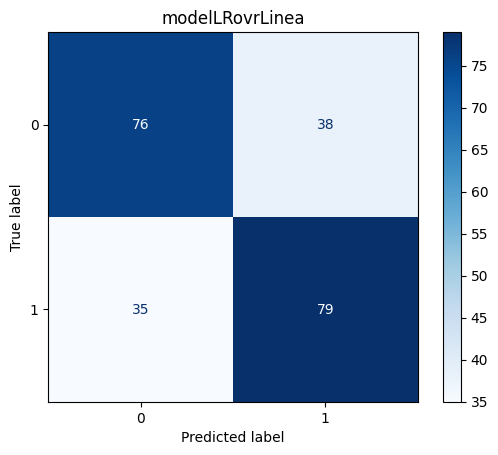

              precision    recall  f1-score   support

           0       0.68      0.67      0.68       114
           1       0.68      0.69      0.68       114

    accuracy                           0.68       228
   macro avg       0.68      0.68      0.68       228
weighted avg       0.68      0.68      0.68       228



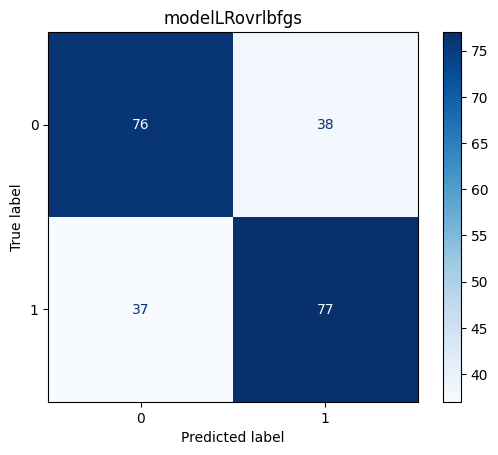

              precision    recall  f1-score   support

           0       0.67      0.67      0.67       114
           1       0.67      0.68      0.67       114

    accuracy                           0.67       228
   macro avg       0.67      0.67      0.67       228
weighted avg       0.67      0.67      0.67       228



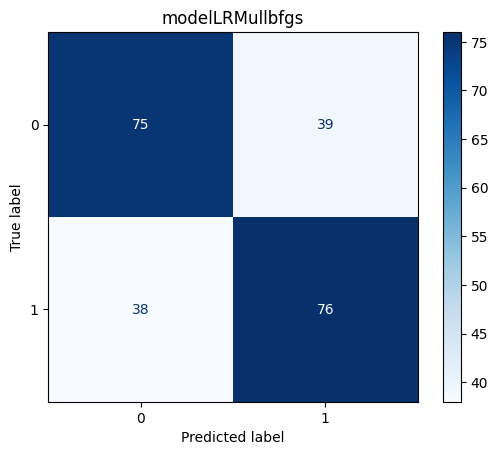

              precision    recall  f1-score   support

           0       0.66      0.66      0.66       114
           1       0.66      0.67      0.66       114

    accuracy                           0.66       228
   macro avg       0.66      0.66      0.66       228
weighted avg       0.66      0.66      0.66       228



In [46]:
# Crear un diccionario de modelos
models = {
    'modelLRovrLinea': [modelLRovrLinea, y_predovrLinea],
    'modelLRovrlbfgs': [modelLRovrlbfgs, y_predovrlbfgs],
    'modelLRMullbfgs': [modelLRMullbfgs, y_predMullbfgs]
}

# Para cada modelo se se extrae un elemento del diccionario models
for model_name, (model, y_pred) in models.items():

    # Calcular la matriz de confusión
    cm = confusion_matrix(y_test, y_pred)

    # Crear la visualización de la matriz de confusión
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))

    # Mostrar la visualización
    disp.plot(cmap='Blues')

    # Mostrar el título usando matplotlib
    plt.title(model_name)

    # Mostrar la figura
    plt.show()

    # Mostrar el informe de clasificación
    print(classification_report(y_test, y_pred))


#### ROC - Receiver Operating Characteristic

AUC: 0.75


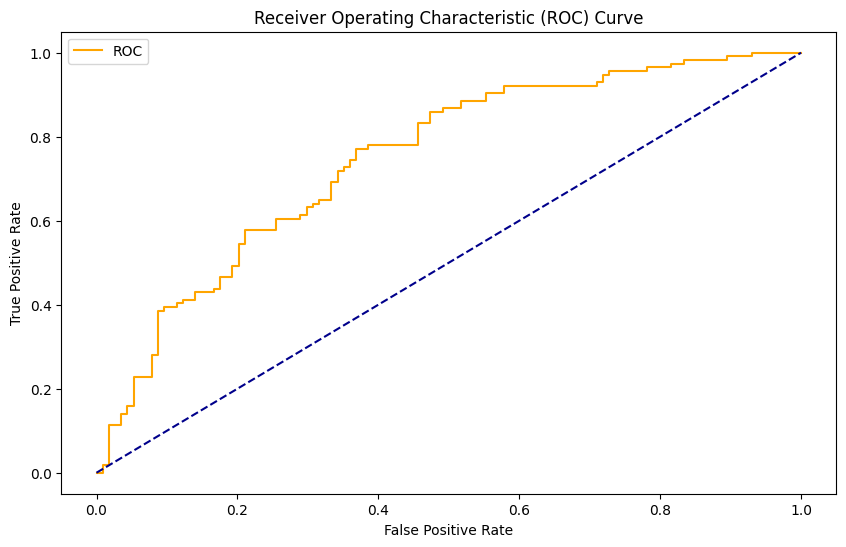

In [47]:
#Curva ROC para un modelo

fig = plt.figure(figsize=(10,6))

# Predecir las probabilidades de la clase positiva usando el modelo de regresión logística entrenado
probs = modelLRovrLinea.predict_proba(X_test)

# Tomar las probabilidades de la clase positiva solamente
probs = probs[:, 1]

# Calcular el área bajo la curva ROC
auc = roc_auc_score(y_test, probs*(1))

# Imprimir el valor del AUC
print('AUC: %.2f' % auc)

# Calcular la curva ROC usando los valores verdaderos y las probabilidades predichas
fpr, tpr, thresholds = roc_curve(y_test, probs*(1))

# Graficar la curva ROC
plot_roc_curve(fpr, tpr)


##Nota: es necesario que la variable de salida sea numérica, sino debe transformarse

### Guardar modelo

In [48]:
#Se guarda el modelo de Regresión logística
joblib.dump(modelLRovrLinea, './modelos/clasificacion/LR_Ret_ovrLineal.pkl')

['./modelos/clasificacion/LR_Ret_ovrLineal.pkl']

#### Referencias


- Regresion Logística

    - https://realpython.com/logistic-regression-python/#regularization
    
    
- Parámetros Regresion Logística

    - https://holypython.com/log-reg/logistic-regression-optimization-parameters/


- *scikit-learn:*   
    - https://scikit-learn.org/stable/modules/svm.html



- *Gráficas con  seaborn:*
    - https://ichi.pro/es/como-utilizar-python-seaborn-para-analisis-de-datos-exploratorios-28897898172180



- *Analítica de grandes datos:*
    - https://jdvelasq.github.io/courses/analitica-de-grandes-datos/index.html